In [40]:
#Import useful modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras import models
from keras import layers

In [41]:
#Set directory and import the Letters data
os.chdir('D:\MSc2\Deep Learning Keras\Task1')
data = pd.read_csv('Mushroom.txt',header=None)

#Randomly shuffle the data
data = data.iloc[np.random.permutation(data.shape[0]),].reset_index(drop=True)

In [42]:
#data.head() #First column is the label (binary)
#data.shape #(8124, 23)
#data.describe()
#data.info() #object
#data.columns.values #column names

In [43]:
##Section 1: Data Preprocessing
#Rename the columns 
data.columns = ["Label"] + ["Feature" + str(num1) for num1 in range(1,23)]

#Remove feature 11 and Rename the columns 
data = data.drop(['Feature11'], axis=1) #Constant values
data.columns = ["Label"] + ["Feature" + str(num1) for num1 in range(1,22)]

#Create features and labels
y = data['Label'].astype("category") #binary labels - pandas series (type categoy)
x = pd.get_dummies(data.iloc[:,1:]) #one-hot-encoding of features - pandas dataframe (type uint8(112))
d = dict(zip(y.unique(), reversed(range(0,2)))) #{'p': 1, 'e': 0}
y = y.map(d, na_action='ignore') #map the labels of Y: Poissonous - 1, Others - 0

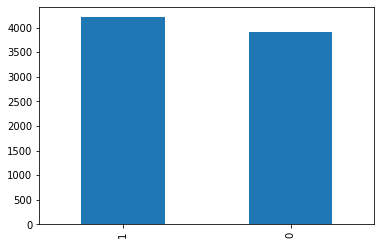

In [44]:
##Section 2. Exploratory Data Analysis
#1) Plot the class label distribution - balanced classes
label_dist = y.value_counts().sort_index() #create a table of counts
label_dist.plot.bar()

In [45]:
##Section 3. Prepare data for modelling
#Split the dataset into training (70%) and testing (30%) dataset
n = data.shape[0]
k = 0.70
q = int(round(n*k))
train_x = x.iloc[:q,:] 
train_y = y[:q]
test_x = x.iloc[q:,:] 
test_y = y[q:]

#Convert to numpy arrays of X and Y
train_x = np.asarray(train_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_x = np.asarray(test_x).astype('float32')
test_y = np.asarray(test_y).astype('float32')

#type(train_x), type(train_y), type(test_x), type(test_y) - (numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)
#train_x.shape, train_y.shape, test_x.shape, test_y.shape - ((5687, 112), (5687,), (2437, 112), (2437,))

In [ ]:
##Section 4. Model Building
#1)Architecture of the model
d = train_x.shape[1]
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(d,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) #Optimizer, Loss function, Metrics

#2)Train the model 
##K-Fold CV
k = 5
num_validation_samples = train_x.shape[0] // k
loss = []
accuracy = []

for i in range(20): #Hyper-param = # of epochs
    l = []
    a = []
    for fold in range(k):
        validation_x = train_x[num_validation_samples*fold: num_validation_samples*(fold+1),:]
        validation_y = train_y[num_validation_samples*fold: num_validation_samples*(fold+1)]
        training_x = np.concatenate( (train_x[:num_validation_samples,:],train_x[num_validation_samples*(fold+1):,:]),
                                    axis = 0)
        training_y = np.concatenate( (train_y[:num_validation_samples],train_y[num_validation_samples*(fold+1):]),
                                    axis = 0)

        model.fit(training_x, training_y, epochs=i, batch_size=128,verbose=0) 

        l.append(model.evaluate(validation_x,validation_y,verbose=0)[0])
        a.append(model.evaluate(validation_x,validation_y,verbose=0)[1])
    loss.append(sum(l)/len(l))
    accuracy.append(sum(a)/len(a))

No handles with labels found to put in legend.


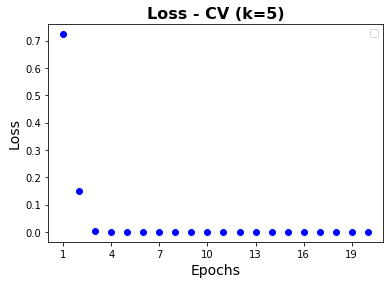

No handles with labels found to put in legend.


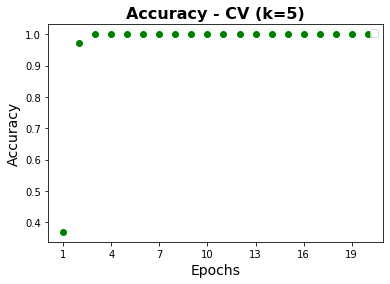

In [47]:
#3)Tuning - Plot loss and accuracy (training vs dev)
loss_values = np.asarray(loss)
accuracy_values = np.asarray(accuracy)

epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values, 'bo')
plt.xticks(range(1, 20,3))
plt.title('Loss - CV (k=5)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.legend()
plt.show()

epochs = range(1,len(accuracy_values)+1)
plt.plot(epochs,accuracy_values, 'go')
plt.xticks(range(1, 20,3))
plt.title('Accuracy - CV (k=5)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.legend()
plt.show()

In [52]:
#4)Finalize - retraining the model using whole training set
d = train_x.shape[1]
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(d,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_x, train_y, epochs=5,batch_size=128,verbose=0) 

In [54]:
#5)Evaluate on the test set
model.evaluate(test_x,test_y) #[loss, accuracy] = [0.01449605622158757, 0.9991793188346327]

2437/2437 [==============================] - 0s 18us/step


[0.01449605622158757, 0.9991793188346327]

(array([1124.,   16.,    5.,    2.,    2.,    2.,    3.,   11.,   29.,
        1243.]),
 array([1.3594765e-06, 9.9610642e-02, 1.9921993e-01, 2.9882920e-01,
        3.9843848e-01, 4.9804777e-01, 5.9765702e-01, 6.9726634e-01,
        7.9687560e-01, 8.9648491e-01, 9.9609417e-01], dtype=float32),
 <a list of 10 Patch objects>)

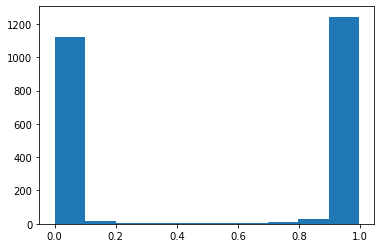

In [55]:
#6)Closer look at the test set performance
predictions = model.predict(test_x) #see the soft probability of the predicted data
plt.hist(predictions)